# 13 Reverse Quantum Annealing with Portfolio Optimization Problem as an example

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/ja/013-ReverseQuantumAnnealing.ipynb)

## はじめに
この章はポートフォリオ最適化問題を例として、OpenJijを用いてリベース量子アニーリング（Reverse Quantum Annealing）という、古典的な最適化計算と、量子アニーリングを組み合わせた手法を紹介する。このチュートリアルでは、古典的なアルゴリズム、普通の量子アニーリング、そしてリバース量子アニーリングそれぞれで同じポートフォリオ最適化問題を解いて、その結果を比較する。また、その過程を通して、OpenJijでの量子アニーリングの実装や実験を行う時の注意点についても議論する。

*注意：このポートフォリオの内容を正しく実行するにはOpenJij0.4.9以上が必要になる。必要な場合は実行前に次のコマンドを実行して、OpenJijのアップデートを行ってください。*
```bash
pip install -U openjij
```

## ポートフォリオ最適化問題
  資産運用して投資活動を行うとき、できるだけリスクを回避しながら大きな収益を実現させたい。なので、収益が限定的であるが、リスクが小さい（ないし全くない）資産と見込める収益が大きい分リスクも大きい資産を組み合わせてポートフォリオを作って分散投資を行うのが一般的な戦略になる。

  この時、与えられた一定のリスクでは最大利益を実現したい、または同じ利益を実現する場合できるだけ小さいリスクを取るには、最適なポートフォリオを選ぶ必要がある。現在、よく利用される手法はMarkowitzによる現代ポートフォリオ理論(Modern Portfolio Theory)であり、ポートフォリオを構成する銘柄の間の相関を考慮して、その共分散を最小にさせるような手法になる[1]。
  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$
  ただし、$w_{i}$は各銘柄がポートフォリオ内に占める重みで、$\sigma_{ij}$は銘柄間の共分散である。$\mu_{i}$は各銘柄の期待収益で、$R$はこのポートフォリオの総収益になる。

  この時、ポートフォリオのパフォーマンスの評価によく使われる指標としてSharpe Ratioというのがある。

  ### Sharpe Ratio
  Sharpe Ratioは投資の効率性を評価する指標で、銘柄単体とポートフォリオに対して計算できる。1966年にウィリアム・シャープによって提案された[3]。その基本的な定義は次のような形になる。
  $$
  S = \frac{\bar{r}-r_0}{\sigma}
  $$
  ここの$\bar{r}$は一定時間内の平均的なリターン率であり、月間や年間リターンの平均を利用することが多い。$r_0$はリスクなしの場合のリターン率で、普段は安定した国債の利子率などを用いる。そして$\sigma$はボラティリティを表していて、資産価値の変動の激しさを意味している。
  
  また、実際にSharpe Ratioを計算する時、場面によって異なる計算方法でこれらの値を算出する。例えばリターンは単純リターンとして$r=P(t+1)/P(t) - 1$で資産価格$P$を使って計算される場合と、$r=log[P(t+1)/P(t)]$のように対数リターン率として計算される場合がある。そしてボラティリティも価格の変動から計算する手法とリターン率からの計算するやり方が存在する。具体的に興味がある方は金融工学や市場分析などに関連する本とサイトに参照してください。

  ### ポートフォリオの評価と最適化
  Sharpe Ratioの定義から、その値が大きいということは収益が大きいまたはリスク（ボラティリティ）が小さいことを意味している。ある与えられた銘柄の集合から作られたポートフォリオのうち、最大のSharpe Ratioを実現できるような組み合わせは、単位リスクに対して最大のリターンを得る組み合わせになる。なので、ポートフォリオの最適化問題が一定の考え方の元ではShape Ratioを最大にする問題に置き換えられる。

  現実において、この最適化は銘柄を選別した上で、それぞれの銘柄に投入する資金の量を決定しなければならない。つまり、選ぶ銘柄と各銘柄のウェイトを決定する問題になる。このチュートリアルは、参考にした論文[2]に従い、簡単のために各銘柄のウェイトを等しくする戦略について考える。この時、問題は$M$個ある銘柄のうち$N$個銘柄を選び出して、実現Sharpe Ratioを最大にするものになる。すると、次のようなQUBO形式に問題を翻訳できる。
  $$
  \mathcal{O}(\boldsymbol{q})=\sum_{i=1}^{N}a_{i}q_{i}+\sum_{i=1}^{N}\sum_{j=i+1}^{N}b_{ij}q_{i}q_{j}
  $$
  ここの$q_{i}$は各銘柄に対する選択で$1$であればポートフォリオに組み入れて、$0$であれば組み入れない意味を持つ。そして$a_i$は銘柄自体のパフォーマンスによる魅力スコアであり、$b_ij$は銘柄間のペアワイズ相関で決められた罰金または賞金の度合を表す。

  具体的に$a_i$と$b_ij$は次の表1に従って決定される。

<div>
    <img src="images/013_RQA_QUBO.png">
</div>


  ここの$a_i$のグループは、ポートフォリオを構成する人によって決められた基準で銘柄を魅力的であるから魅力ではない順で並べて、それらを順位付けした後に、均等に分けた場合に形成されたグループである。この魅力的な基準はリターン率の高さなどの要素も取り入れられるが、このチュートリアルでは単純に銘柄単体のSharpe Ratio順を用いた。そして$b_{ij}$は対数リターンの時系列から求められた相関行列の成分$\rho_{ij}$の値によって決められている。

  このQUBOを使って量子アニーリングを行えば、最適のポートフォリオを得ることができるはずである。また、選択銘柄の数について指定したい場合はこのチュートリアルシリーズで既に説明があったように銘柄数に対して罰金法の制限を付け加えればできる。ただし、参考にした論文[2]によると、罰金法を利用した場合、導入した大きい相互作用（ペナルティ）はアニーリングの性能や最終的に取得した結果にも影響するのも分かる。さらに、最適のポートフォリオに含まれる銘柄の数が分からないのがより現実的であるので、このチュートリアルでは銘柄数制限なして最適化を行う。

## Reverse Quantum Annealingによるポートフォリオ最適化
現実のポートフォリオ最適化の問題は基本、大きな銘柄数を持つ市場からいくつかの銘柄を選択することになる。候補銘柄数の増加によって最適のポートフォリオを作るための計算量が非常に大きくなる。なので、一定の条件の下に選別を行ってから最適化アルゴリズを適応させるのが普通である。そして、銘柄の組合せの自由度から、最終的の実現Sharpe Ratioが最大Sharpe Ratioと極めて近い値を持つ非最適解が多く存在することもあり得る。伝統的なアルゴリズムがそのような解にハマった場合抜け出すにも時間とリソースが必要となる。そのため、以上の既存な問題点を回避しながらポートフォリオ最適化問題を解くには、量子アニーリングのような大きい数の相関を取り扱えてローカルミニマムから脱却できる技術が有利である。

ただし、参考論文[2]に示されたように、単純なForward Annealingのみを行う場合、銘柄数の増加によって、最適解までにたどり着く時間も大きく増加して、伝統的の遺伝アルゴリズムと近いパフォーマンスになるのが分かる。その理由としてはやはり最適解と近い値のSharpe Ratioを持つ解と最適解はエネルギーの違いも小さいので、最適解への変化がほとんどエネルギー差がほぼない準位の間で高いポテンシャルの障壁がある場合の遷移になるため、遷移が起こるまでにより長い時間が必要となるからである。また、量子アニーリングマシンの実機では通常のアニーリングを行う途中で熱ノイズなどによる影響で系が励起されて時間発展する場合もあって、それによって最終の結果が最適解とならない可能性もある。


### Reverse Quantum Annealing
これらの量子アニーリングを用いた時の問題点を解決するために提案された手法の一つは、Reverse Quantum Annealingである。名前通り、通常のForward Annealingと逆方向のステップを導入するような量子アニーリングを指す。通常のForward Annealingの時間依存のハミルトニアンは次のように書ける。
$$
\mathcal{H}_{\mathrm{QA}}(t)=A[t]\sum_{i=1}^N\sigma_{i}^{\mathrm{x}}+B[t]\mathcal{H}_{\chi-\mathrm{Ising}}
$$
この$A[t]$はアニーリングを行うとき系にかける横磁場を表していて、$B[t]$は問題のハミルトニアン$\mathcal{H}_{\chi-\mathrm{Ising}}$の振幅になる。次の図でのa)で示されるように、Forward Annealingの場合はアニーリングの侵攻によって、$A[t]$がだんだん小さくなり、同時に$B[t]$主導的になっていく。最終的にアニーリングが完了するときは$A[t]=0$になる。

<div>
    <img src="images/013_QAandRQA.png">
</div>

対してReverse Annealingはb)のように$A[t]=0,B[t]=1$の状態から出発して、まず通常と逆に$B[t]$を小さくしていく。これはReverse Phaseになる。この段階では系のエネルギーが逆に高くなるため、c)に示されたようなAとBの間のポテンシャル障壁は超えやすくなる。そしてある値に達するとそのまま系を維持してしばらく待つ。これはPause Phaseになる。この時もまた高いエネルギーの状態のままであり、熱的ホッピングが起こりやすいため、Bの右のようなポテンシャルの山も超えやすくなる。結果的に最初に入ったローカルミニマムから脱して最適解付近にたどり着く可能性が上がる。最後にまた$A[t]$を小さくして、$B[t]$を大きくさせるForward Phaseで通常のアニーリングをして、最適解を取得する。この時、Reverse Annealingを止めた場所や、各段階に使った時間などによって、最後のパフォーマンスにも影響するのが考えられる。


### Reverse Quantum Annealingによるポートフォリオ最適化の手順
このReverse Quantum Annealingの手法を実行するにはもう一つの条件がある。それがReverse Phaseの初期状態が必要である。この状態はランダムに生成された初期状態を用いても可能ではあるが、手法が提案された背景からも、最適解探索の効率の観点からもある種類のローカルミニマム状態を用意したほうが良いと分かる。その初期状態になるローカルミニマムを得るには参考論文[2]では伝統的なアルゴリズムで得られた出力を利用した。このチュートリアルもそれに従う。

なので、これから行う実装は基本論文[2]の流れを参考にして以下のようになる。
- 最適化を行う銘柄データの生成
- 古典なアルゴリズムの実装とその結果の確認
- 通常のForward Annealingによる最適解探索
- Reverse Quantum Annealingによる最適解探索
- Reverse Quantum Annealingのパラメータ探索

## 銘柄データの生成と古典アルゴリズムの実装

### 最適化を行う銘柄データの生成
参考論文[2]にある方法に従って、与えられた初期値を用いて、ブラウン運動による銘柄チャートを生成する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

参考論文[2]の付録Aによって、各時刻においてチャートの運動は前の時刻の運動によって
$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$
のように与えられる。ここの$Z_n$はcholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布になる。

それを実行してチャートをプロットして様子を確認する。最初が同じところから始めても一年間経つと、全体が広がっていく様子は分かる。また一部銘柄が大きく上昇または降下するのも確認できる。

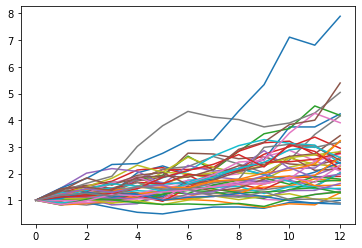

In [2]:
#相関正規確率変数Znの生成
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

#チャートのブラウン運動の生成
def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48 #生成する銘柄の数
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12) #Z variable shuffle

for label in Zlabels:
  ZList.append(Zvariables[label])

for iasset in range(Nassets):
  chart_asset = [1.0] #初値 相対価格で1.0

  #12ステップ（か月）シミュレーションを行う
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))

  chart.append(chart_asset)
  #print(chart_asset) #各銘柄の具体的な数値をプリント
  plt.plot(list(range(13)), chart_asset)

plt.show()

銘柄のデータを生成できたので、各銘柄のSharpe Ratioを計算する。ここの結果を評価するに使うのは実現Sharpe Ratioで、その定義に従って無リスク利回り率を超過した超過収益率の平均$\bar{r}$と超過リターン率の標準偏差$\sigma$で求める。チャートを確認するとき分かったように、銘柄数が少ない場合は偶然による偏りが大きい、かつ生成条件に銘柄間に相関があるので、銘柄を100回生成してその平均Shape Ratioの確認することでそれらの影響を減らす。結果として、銘柄の平均Sharpe Ratioが期待通り$0.4$になるのを確認できる。また、Sharpe Ratioの計算定義を変更した場合、Sharpeの値が変化するのも確認できるが、おおむね$0.40\pm0.05$の範囲内には収まるのも分かる。

In [3]:

#銘柄生成関数
def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

#オーソドックスなSharpe Ratio
def CalculateSharpeRatio(asset):
    monthly_return = list()
    for month in range(12):
      valueChange = asset[month+1]/asset[month] - 1.0 - r0
      monthly_return.append(valueChange)

    annualized_excess_return = np.mean(monthly_return)
    volatility = np.std(monthly_return, ddof=1)

    return(annualized_excess_return/volatility)

#log-returnに基づいたSharpe Ratio
def CalculateSharpeRatio_log(asset):
  monthly_log_return = list()
  for month in range(12):
    valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(valueChange)
  mean_log_return = np.mean(monthly_log_return)
  volatility = np.std(monthly_log_return, ddof=1)

  return (mean_log_return-r0)/volatility

#少し変わった定義のSharpe Ratio
def CalculateSharpeRatio_2(asset):
  monthly_log_return = list()
  monthly_return = list()
  for month in range(11):
    log_valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(log_valueChange)
    valueChange = asset[month+1]/asset[month] - 1.0
    monthly_return.append(valueChange)
  annualized_excess_return = np.mean(monthly_return) - r0
  volatility = np.std(monthly_log_return, ddof=1)

  return (annualized_excess_return/volatility)

allmean = 0
for ntry in range(100): #複数回試行で同じセットないの相関による影響を消す
  Chart = CreateAssets(48) #指定した数の銘柄を作る
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset) #ここを変更すればShape Ratioの計算方法を変えられる
    #assetSR = CalculateSharpeRatio_log(asset)
    #assetSR = CalculateSharpeRatio_2(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1) #平均Shape Ratio
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.2620594165006169
Average Sharpe Ratio of all generated: 0.2620594165006169
SubSet 1 average Sharpe Ratio: 0.455828073775449
Average Sharpe Ratio of all generated: 0.35894374513803295
SubSet 2 average Sharpe Ratio: 0.5303305858112491
Average Sharpe Ratio of all generated: 0.4160726920291051
SubSet 3 average Sharpe Ratio: 0.43750001277301503
Average Sharpe Ratio of all generated: 0.42142952221508256
SubSet 4 average Sharpe Ratio: 0.3134297390839592
Average Sharpe Ratio of all generated: 0.39982956558885785
SubSet 5 average Sharpe Ratio: 0.3369849360882124
Average Sharpe Ratio of all generated: 0.38935546067208365
SubSet 6 average Sharpe Ratio: 0.47147204114944685
Average Sharpe Ratio of all generated: 0.4010864007402784
SubSet 7 average Sharpe Ratio: 0.2741389145291232
Average Sharpe Ratio of all generated: 0.385217964963884
SubSet 8 average Sharpe Ratio: 0.5482360311144064
Average Sharpe Ratio of all generated: 0.40333108342505314
SubSet 9 average Sharpe

### 古典アルゴリズムによる探索
続いてはQUBO行列の準備及び古典なアルゴリズムに必要な関数を実装する。ここで、ペアワイズ相関行列は論文に従い対数リターンで計算した。

In [4]:
import heapq
import pandas as pd
import copy

#Attractiveness Coversion
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

#Penalty/Reward Conversion 
def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

#Ising component for classical algorithms
def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]

#Create Pairwise Correlation Matrix
def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

#Initial state for Greedy Search and Genetic Algorithm
def GenerateRandomSolution(Nassets):
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    return Solution

#得られた解のポートフォリオのSharpe Ratioを計算する
def EvaluateSolution(Solution,Chart):
    selected_assets = list()
    for i in range(len(Solution)):
        if Solution[i] == 1:
            selected_assets.append(Chart[i])
    portfolioChart = np.mean(selected_assets, axis=0)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    return portfolioSR

#遺伝アルゴリズム、突然変異を導入して子孫を作る
def CreateDescendant(Ancestor, Ndescendants, MaxMutation):
    n = 0
    index_list = range(len(Ancestor))
    Descendants = list()
    while n < Ndescendants:
        Nmutaion = np.random.randint(MaxMutation)
        Place_to_change = np.random.choice(index_list, size=Nmutaion, replace=False)
        Descendant = list()
        for place in Place_to_change:
            Descendant = copy.deepcopy(Ancestor)
            Descendant[place] = Ancestor[place] * -1
            Descendants.append(Descendant)
        n += 1
    return Descendants


In [5]:
#銘柄セットを再生成する
#ここからさっきのステップはこの銘柄セットをずっと使う
Nassets = 48

Chart = CreateAssets(Nassets)
PairwiseCorrMat = CreateCorrMat(Chart)
SR_list = list()

for asset in Chart:
    SR_list.append(CalculateSharpeRatio(asset))

#Bucketの翻訳
SRBucket(SR_list)
CorrelationBucket(PairwiseCorrMat)

#print(PairwiseCorrMat)　#ペアワイズ相関行列の確認


#### 貪欲サーチ
まずは貪欲サーチのアルゴリズムで探索を行う。ランダムに生成した初期状態から出発して、全体のパフォーマンスに対する影響を見ながら、ポートフォリオのSharpe Ratioを高くできそうな銘柄を選んでいくアルゴリズムである。イタレーションを行うことで、ランダムな初期状態からある一定の状態に落ち着くことを観測できる。

実行後、初期状態と貪欲サーチで得られた状態の比較を行う。このとき比較の基準がポートフォリオのSharpe Ratioになる。このチュートリアルでは全銘柄のウエイトが同じというシナリオなので、選ばれた銘柄の平均的なチャートを得てSharpe Ratioの計算を行った。

また、一個前のコードブロック複数回実行して銘柄セットをリセットすると、貪欲サーチの結果は初期状態よりも悪くなったり、ほぼ変わらなかったりする場合もあるのが分かる。そして最終的なリターンが初期状態に負けたが、Sharpe Ratioが大きい最終状態もある。それらを比較すると、Sharpe Ratioが大きい場合ポートフォリオのチャートが滑らかで、変動が小さくリスクが非常に小さいのが分かる。

Initial random selection:
[ 1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1  1 -1  1
 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1 -1 -1] 1.0848187187887222

Selection After Greedy Search:
[-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1
 -1  1  1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1] 2.801489861942124



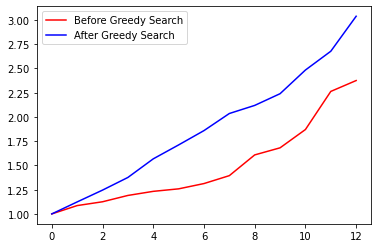

In [6]:
#Greedy Search

#初期状態生成
Solution = GenerateRandomSolution(Nassets)
print("Initial random selection:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)

#初期状態に基づいてエネルギーの初期化を行う
Energies = list()
for iasset in range(Nassets):
    h = hi(SR_list, PairwiseCorrMat, iasset)
    energyTuple = [-1*abs(h), h , iasset]
    Energies.append(energyTuple)

#貪欲サーチの実行
NGreedyLoop = 10
for i in range(NGreedyLoop):
    heapq.heapify(Energies)

    ntry = 0
    #print(Energies) #エネルギー変化を確認
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(PairwiseCorrMat, i, n) + jij(PairwiseCorrMat, n, i))
            ie[0] = -ie[1]
        ntry+=1


#貪欲サーチの出力
print("Selection After Greedy Search:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts2 = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts2.append(Chart[i])
portfolioChart2 = np.mean(selected_charts2, axis=0)

plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.legend()
plt.show()

#### 遺伝的アルゴリズム

貪欲サーチのほかに使われた古典アルゴリズムは遺伝的アルゴリズムである。ランダムに生成した複数のポートフォリオからパフォーマンスが良いものを選択して、その良いポートフォリオをもとにして次の世代のポートフォリオを生成する。次の世代のポートフォリオは前の世代のポートフォリオにランダムな変更を加える突然変異と、ポートフォリオ間の遺伝子を交換させるなどで生成できる。ここでは銘柄数が比較的に小さいため、突然変異のみを考えていて、遺伝子間の交換や交配を行わなかった。

結果を比較することで、ラスト世代が第一世代よりもパフォーマンスが良くなっていることを観測できる。ただし、ここで試行した世代数が限られているため、パフォーマンスが改善されないまたは改善が小さい場合もある。そして総じて貪欲サーチよりも安定な出力が得られるのも観察できる。

注意：遺伝子の組数や子孫数、そして変異の数を増やした場合計算量の増加により計算が終わらない場合もあるので、実行環境に合わせて設定を変えてください。

Best Gene 1st generation:
[ 1  1 -1  1  1 -1  1 -1 -1  1 -1  1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1  1] 1.9718144849525687

Best Gene last generation:
[ 1  1 -1  1  1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1  1 -1  1] 2.1226446968308657



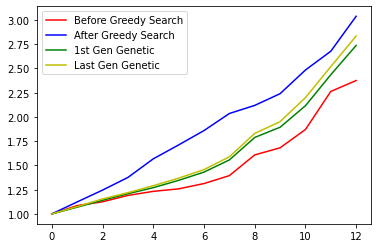

In [8]:
#Genetic Algorithm
Ngenes = 10 #遺伝子の組数
NGenerations = 5 #世代数
#ランダム初期化
Genes = list()
for i in range(Ngenes):
    gene = GenerateRandomSolution(Nassets)
    geneSR = EvaluateSolution(gene, Chart)
    Genes.append([geneSR, gene])
Genes = sorted(Genes,reverse=True)

#第一世代最優良ポートフォリオ
print("Best Gene 1st generation:")
print(Genes[0][1], EvaluateSolution(Genes[0][1], Chart))
print("")

selected_charts3 = list()
for i in range(Nassets):
    if Genes[0][1][i] == 1:
        selected_charts3.append(Chart[i])
portfolioChart3 = np.mean(selected_charts3, axis=0)


#遺伝的アルゴリズム実行
K_best = 5 #上位抽出遺伝子組数
Ndescendants = 2 #子孫数
MaxMutation = 2 #最大変異数
for iIter in range(NGenerations):
    selected_Genes = Genes[:K_best]
    for gene in selected_Genes:
        Descendants = CreateDescendant(gene[1], Ndescendants, MaxMutation)
        for Descendant in Descendants:
            DescendantSR = EvaluateSolution(Descendant, Chart)
            selected_Genes.append([DescendantSR, Descendant])
    selected_Genes = sorted(selected_Genes, key=lambda x: x[0], reverse=True)
    selected_Genes = copy.deepcopy(selected_Genes[:K_best])

#ラスト世代最優良ポートフォリオ
print("Best Gene last generation:")
print(selected_Genes[0][1], EvaluateSolution(selected_Genes[0][1], Chart))
print("")
selected_charts4 = list()
for i in range(Nassets):
    if selected_Genes[0][1][i] == 1:
        selected_charts4.append(Chart[i])
portfolioChart4 = np.mean(selected_charts4, axis=0)

#比較プロットを作る
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.plot(list(range(13)), portfolioChart3,color="g",label="1st Gen Genetic")
plt.plot(list(range(13)), portfolioChart4,color="y",label="Last Gen Genetic")
plt.legend()
plt.show()


## Open Jijを用いた量子アニーリング手法の実装

### Quantum Annealingによる解法
Reverse Quantum Annealingでこの最適問題解くために、古典なアルゴリズムで得られたスピン形式の結果をアニーリングが使う形式に変換する。

In [9]:
def ConvertSolutionToQuboState(solution):
    output = list()
    for i in range(len(solution)):
        if solution[i] == 1:
            output.append(1)
        else: output.append(0)
    return output

QA_init_state = ConvertSolutionToQuboState(Solution) #貪欲サーチの結果を初期状態として使う
#QA_init_state = ConvertSolutionToQuboState(selected_Genes[0][1]) #遺伝的アルゴリズムラスト世代の最優良ポートフォリオを初期状態として使う
#QA_init_state = GenerateRandomSolution(Nassets) #ランダムな初期状態を使う
print(QA_init_state)
    

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]


#### Forward Annealingの場合
銘柄の魅力度とペアワイズ相関による罰金と賞金の度合を使ってQUBO行列を作り、まずForward Annealingを実行する。最終リターン率の改善はケースバイケースになるが、結果として貪欲サーチの結果よりも安定したチャートを得られている。

<class 'numpy.ndarray'>


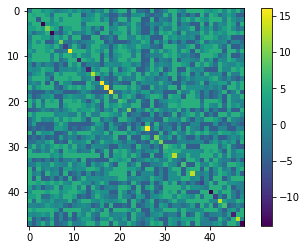

[([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

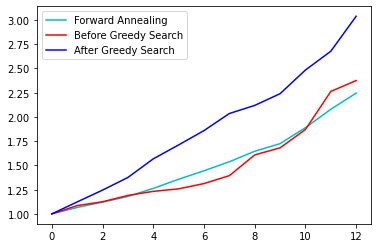

In [10]:
from openjij import SQASampler
sampler = SQASampler()

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

print(type(QUBO))
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset_FQA = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset_FQA.record)
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
selected_charts = list()
for i in range(Nassets):
    if sampleset_FQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.legend()
plt.show()


#### Reverse Quantum Annealing(RQA)の場合
Reverse Annealingの場合、まずは古典的アルゴリズムから得られた状態を初期状態として入力してからアニーリングを行う。この時はまずアニーリングのスケジュールを設定する必要がある。SQAのハミルトニアンは次のようになる。
$$
\mathcal{H}_{\mathrm{SQA}}(s) = s\mathcal{H}_{p}-(1-s)\sum_{i}\sigma_{i}^{x}, 0\leq x\leq 1
$$
ここの$\mathcal{H}_{p}$は問題のハミルトニアンで￥、$s$と$1-s$はそれぞれ参考論文[2]の$B[t]$と$A[t]$に対応する。この$s$の設定は
```python
sample_qubo(QUBO, num_reads=10)
```
に追加の引数を指定することによってできる。初期状態の設定や更新を含めて
```python
sample_qubo(QUBO, schedule = user_schedule, initial_state = user_initial_state, num_reads=10, reinitialize_state = False)
```
のように変更すればよい。ここのscheduleはアニーリングスケジュールを指していて、
```python
user_schedule = [
    [0, 0.1, 4], #s=0, beta=0.1, 4 steps
    [0.5, 1, 3],  #s=0, beta=1, 4 steps
    [1, 10, 3]  #s=1, beta=10, 3 steps
]
```
のような構造を持つ、格納されたリストの```[0]```成分は$s$の値で、アニーリングするときの横磁場の強さを反映する。```[1]```成分は逆温度$\beta$で、大きければ低い温度を意味し、より基底状態に戻りやすくなる。デフォルトでは$\beta = 5$で設定されている。そして最後の```[2]```成分は量子モンテカルロ法のシミュレーションステップ数を表していて、各スケジュールの長さを調整できる。

そして`initial_state`が代入する初期状態である。`reinitialize_state`のオプションが`False`にすることで、毎回実行した出力がまた初期状態として代入されて次のアニーリングを行う意味で、上の関数はある初期状態から出発してRQAを10回イタレーションする意味になる。このオプション引数がデフォルトでは`True`で、実行するたびに初期状態の再設定を行っている。RQAを一回実行させ、複数回の結果を比較したい場合は`True`で問題ない。

ではReverse Annealingのスケジュールを作成する。OpenJijのsamplerは指定された$s$と$\beta$を指定したMC stepの数で量子モンテカルロを実行ので、短い定数をつなぎ合わせて$s$や$\beta$が少しずつ変化するようなスケジュールを作ってRQAの動作を作る必要がある。ここでは$s$の変化に注目してそれをプロットすると逆さまの台形のスケジュールを確認できた。横軸は量子モンテカルロ法のステップ数になる。スケジュール作成の関数を書き換えればそのほかの形のスケジュールも簡単に作成できる。

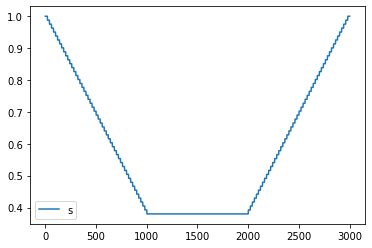

In [11]:
def ScheduleFunction(x, RQAschedule):
    for step in RQAschedule:
        length = step[2]
        if x - length > 0:
            x = x-length
            continue
        else:
            s = step[0]
            return s


def ConvertScheduleToPlot(RQAschedule):
    TotalLength = np.sum(RQAschedule, axis=0)[2]
    x = np.arange(0, TotalLength+1)
    s = [ScheduleFunction(n, RQAschedule) for n in x]
    plt.plot(x, s ,label="s")
    plt.legend()
    plt.show()

#Create RQA schedule
RQAschedule = []
NReverseStep = 50
NPauseStep = 50
NForwardStep = 50
NMCStep = 20
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, NMCStep]
    RQAschedule.append(step_sche)   

#Pause Step
RQAschedule.append([TargetS, beta, NPauseStep*NMCStep])

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, NMCStep]
    RQAschedule.append(step_sche)

#Plot Annealing Schedule
ConvertScheduleToPlot(RQAschedule)

作られたスケジュールを使って、初期状態を指定した`sample_qubo`関数を使って、RQAを実行する。そして同様に、貪欲サーチの結果やForward Annealingの結果の比較を行う。結果を見ると、このチュートリアルが行う設定では銘柄セットのサイズ制限によってForward Annealingと同じ最適解にたどり着く場合が多いのが分かる。

[([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

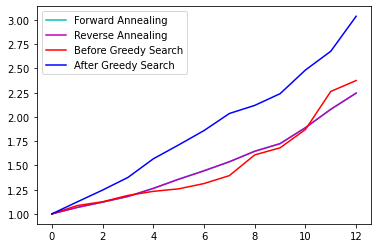

Forward Quantum Annealing Result:
[0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1
 0 1 0 1 1 0 1 0 1 1 1] 3.356689242547606
Reverse Quantum Annealing Result:
[0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1
 0 1 0 1 1 0 1 0 1 1 1] 3.356689242547606


In [13]:
#初期状態を準備
init_state = QA_init_state

#Reverse Annealing
sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
print(sampleset_RQA.record)

#チャートの比較
selected_charts = list()
for i in range(Nassets):
    if sampleset_RQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart_RQA, color="m", label="Reverse Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.legend()
plt.show()
#結果の比較
print("Forward Quantum Annealing Result:")
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
print("Reverse Quantum Annealing Result:")
print(sampleset_RQA.record[0][0], EvaluateSolution(sampleset_RQA.record[0][0], Chart))

### Reverse Quantum Annealingの確認
同じ状態になると、実際にRQAの様子が分からないので、Phaseを分解してRQAを実行してみる。まずはReverse Phaseの確認である。同じようにアニーリングスケジュールを設定して、スケジュールと初期状態を指定したアニーリングを行う。ここでは例が分かりやすくなるようにReverse Phaseが止まる$s$の値や逆温度の設定を変えた。また、アニーリングもイタレーションではなく、毎回同じ初期状態から始まるように設定した。結果を見ると、逆転したアニーリング過程によって、既に得られた解から、よりエネルギーの高い状態に登っていったことが分かる。また、ほぼ毎回異なる状態で留まるので、高いエネルギー准位で解が定まっていないのもわかる。

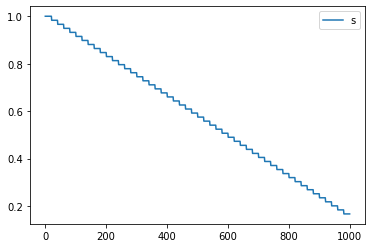

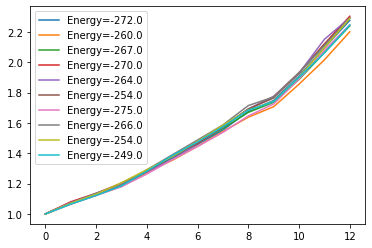

[([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -272., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], -260., 1)
 ([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], -267., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -270., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -264., 1)
 ([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -254., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

In [14]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
ReverseStep = (1.0 - TargetS) / NReverseStep
beta = 5.0
MC_step = 20
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, MC_step]
    RQAschedule.append(step_sche)   

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 
    

sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.legend()
plt.show()
print(sampleset_RQA_Reverse.record)

Reverse状態の確認ができたので、このままPause Phaseの追加を行う。追加後は同様にアニーリングを実行して、その結果を確認した。このPhaseの追加は実装上において上のReverse Phaseの一番最後のステップのMCステップ数を伸ばしたものに等しいので、上のReverseのみのケースと同じようにバラバラの結果になる。

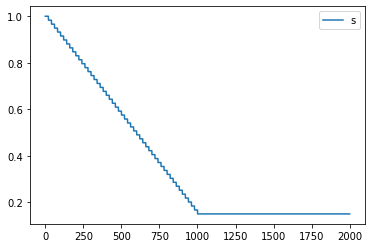

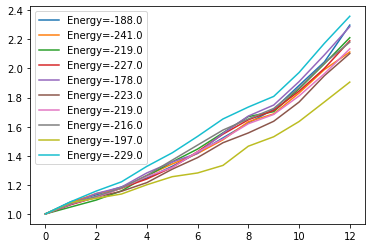

[([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1], -188., 1)
 ([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], -241., 1)
 ([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -219., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], -227., 1)
 ([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -178., 1)
 ([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], -223., 1)
 ([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0

In [15]:
#Create Pause Step
NPauseStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
beta = 1.0 #より高い温度で熱的動きがしやすくようにする
MC_step = 20
step_sche = [TargetS, beta, MC_step*NPauseStep]
RQAschedule.append(step_sche)

#print(RQAschedule)
ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause.record)


最後にForward Phaseをまた追加してアニーリングを行う。ここの設定はこのチュートリアルの前のサンプルよりも少し緩い温度や磁場の条件で行った。結果として、この銘柄セットで既知の量子アニーリングによる最適解が得られたのが分かる。これでRQAの節の最初の例でもちゃんとRQAによって最適解を出しているのが分かる。

また、条件が少し緩いため、解が収束せずに、エネルギーが近い複数のsub-optimalの解の存在を確認することができる。そのなかは場合によって、量子アニーリングの最適解よりも最終的なリターンが良くて、形も比較的に滑らかなポートフォリオの存在も確認できる。そのポートフォリオの詳細を見ると、その大きなリターンは上昇率が大きい特定の銘柄によるもので、逆相関を持つ変動率が比較的に小さい銘柄と組み合わせて実現されたものだと分かる。実際の投資においてはそのようなポートフォリオが好ましいかもしれないが、このチュートリアルが設定した「Shape Ratioがとにかく最大になる」条件では、相対的に小さいポートフォリSharpe Ratioが実現されたことから、量子アニーリングによって最適ではない解と判断された。

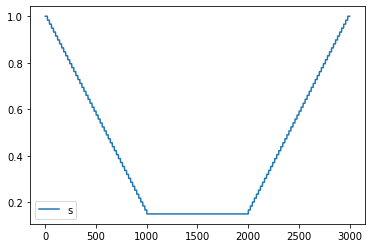

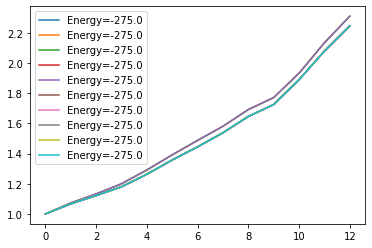

[([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], -275., 1)
 ([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

In [16]:
#Create Forward Step
NForwardStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.0 #より高い温度で熱的動きがしやすくようにする
MC_step = 20

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, MC_step]
    RQAschedule.append(step_sche)

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause_Forward.record)


### RQAスケジュールを指定するときのパラメータ探索
Phaseを分けてReverse Quantum Annealingの様子を確認するところで、スケジュールの設定に指定した$s$,$\beta$そして量子モンテカルロ法のステップ数によって結果が変化することが分かった。つまり、Reverse Annealingでパフォーマンスを良くするには適切な値を設定する必要がある。

#### Reverse Phaseの場合
まずはそれらがReverse Phaseに対する影響を見る。量子アニーリングの度合を表す$s$の影響を見る、これは横磁場をどれぐらい強く戻すのかを表す量で、最初のアニーリングで辿り着いたミニマムの周りになるポテンシャル障壁を超えて状態がばらけるようにするために、それを適切に強く（$s$を小さく）設定しなければならない。このノートの結果では$s$が$0.20$までReverse Phaseの終状態のばらつきがあっても不定にはならず、$0.20$以下だと熱的揺らぎが支配的になり、ばらつきが大きくなったのが分かる。なので$0.2$あたりをさらに細かくスキャンすれば最適の$s$値を得られる。

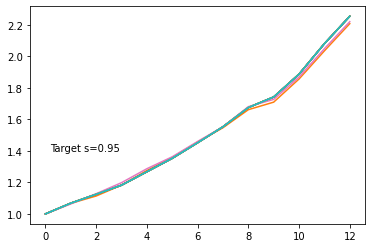

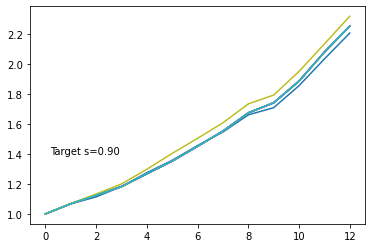

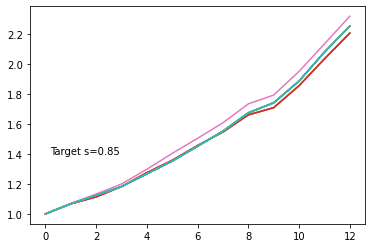

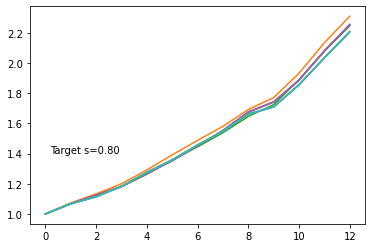

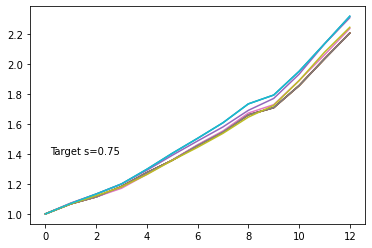

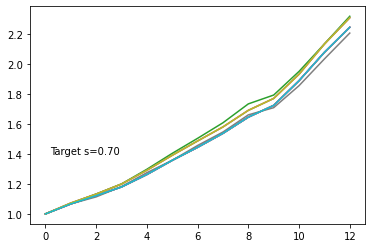

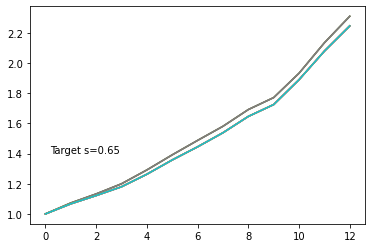

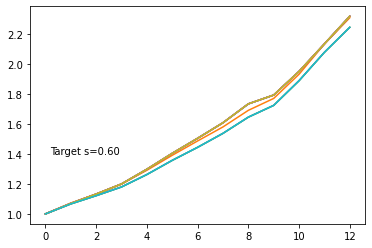

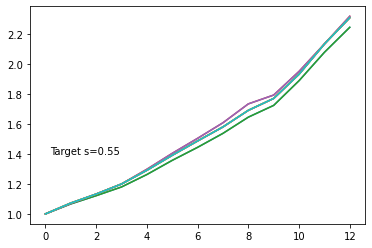

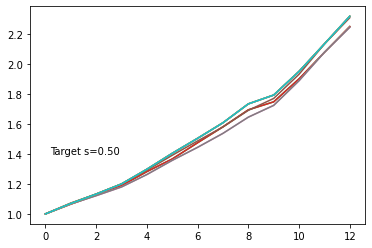

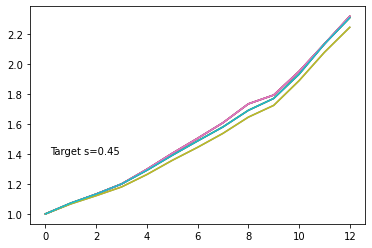

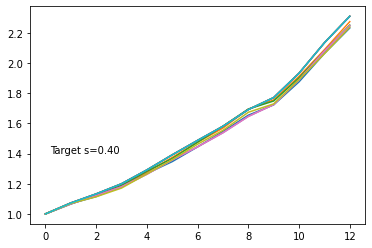

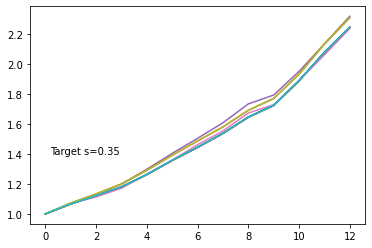

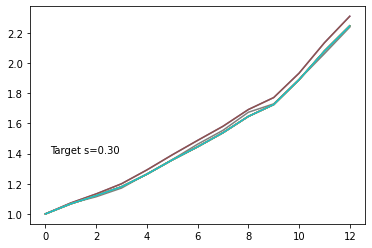

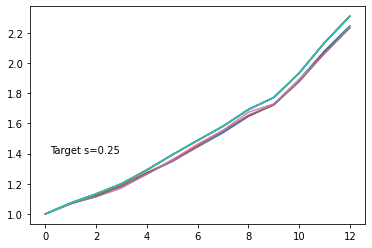

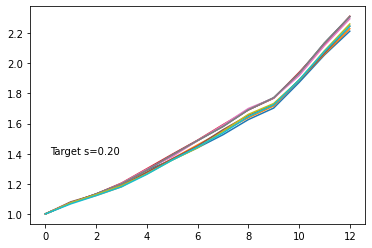

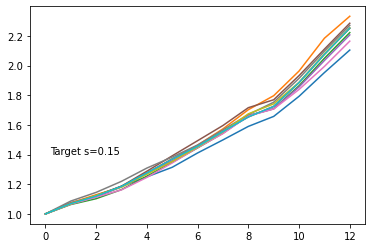

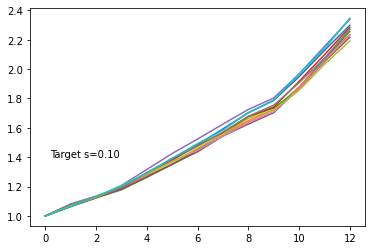

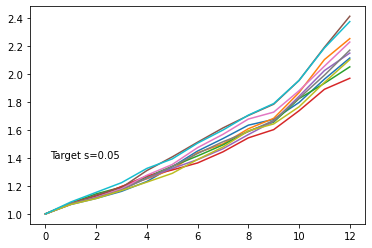

In [17]:
for TargetS in reversed(np.arange(0.05, 1.0, 0.05)):
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.text(0.2,1.4, "Target s="+'{:.2f}'.format(TargetS))
    plt.show()

次に$\beta$による影響を調べる。$\beta = \frac{1}{k_{\mathrm{B}T}}$が逆温度を表していて、$\beta$が大きければ大きいほど、系がより低温である意味になる。それはつまり全体としては状態がより基底状態に落ちやすく、より「Annealed」な状態に近いふるまいをする。言い換えると横磁場が一定の場合、$\beta$が大きくなると、横磁場が効きにくくなり、実効的には大きい$s$に近いふるまいになる。OpenJijにおいてその影響の詳細を知りたい方はこの[Qiita記事](https://qiita.com/ground0state/items/0f61c3efc7f12fd96d05)に参照してください。

また、その影響はQUBO行列に入っているエネルギーんの典型的なスケール付近で変わることも分かっている。このチュートリアルの場合、QUBOに入っている典型な値は$[-5,5]$の範囲に入るため、$\beta=5.0$付近でふるまいが変化すると予想できある。

(array([  4.,   4.,   4., 590., 532., 516., 634.,   5.,   5.,  10.]),
 array([-14., -11.,  -8.,  -5.,  -2.,   1.,   4.,   7.,  10.,  13.,  16.]),
 <BarContainer object of 10 artists>)

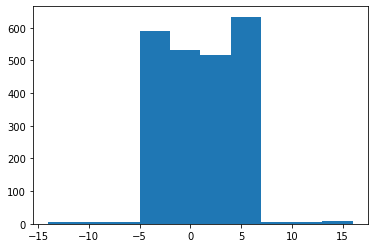

In [18]:
plt.hist((QUBO).flatten())

対数的な$\beta$配列を用意して、$s$以外の量を固定してReverse Phaseを行う。予想通り$\beta=5$あたりで終状態のばらつきが小さくなり、それよりも大きい$\beta$だと数少ない状態に収束してしまうことが分かる。

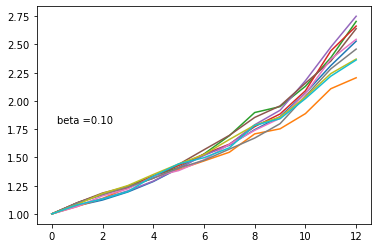

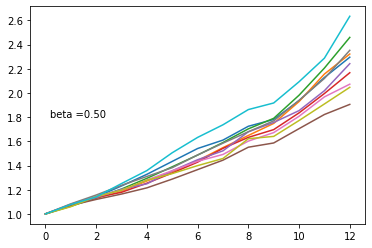

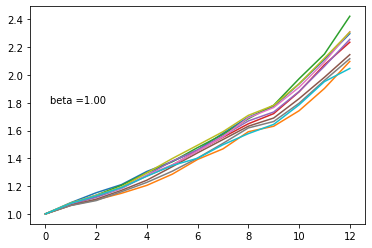

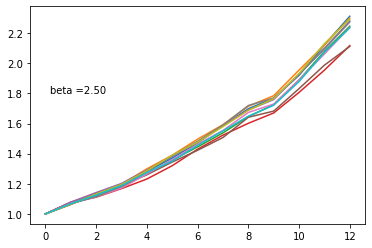

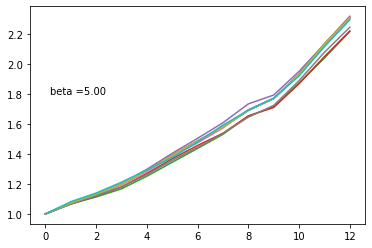

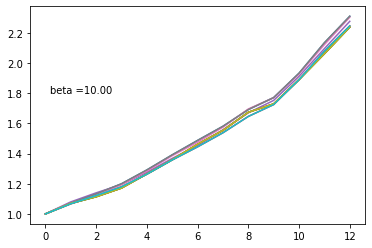

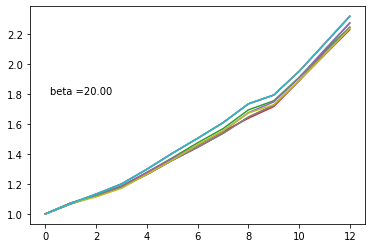

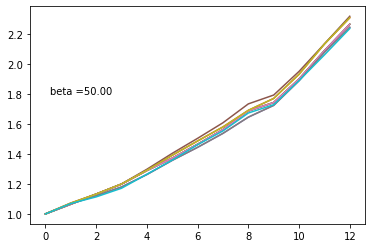

In [19]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.text(0.2,1.8, "beta ="+'{:.2f}'.format(beta))
    plt.show()

そしてスケジュールの分割について調べる。階段関数のような極端的な場合から、細かく分割して緩やかな変化にする場合まで調査をした。結果から分かるように、分割数が少ない場合、状態があまり変化せず、増やすとばらつきが見えてくる。また、大きく増やしても計算時間が長くなるだけで結果の違いが少ないのも分かる。このチュートリアルが取り扱うポートフォリオ最適化問題の場合は$50$程度の設定で問題ない。

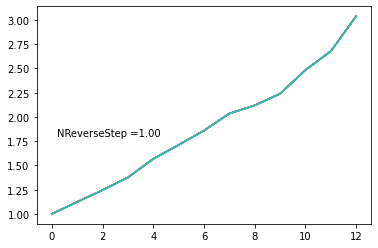

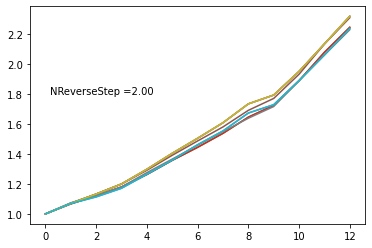

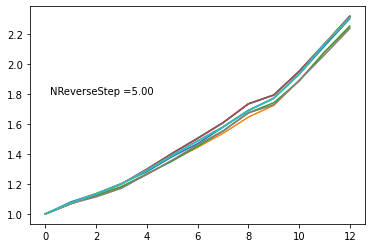

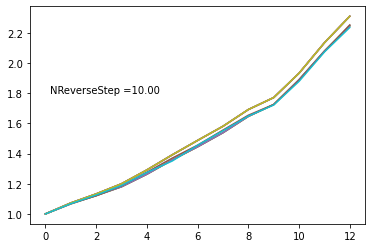

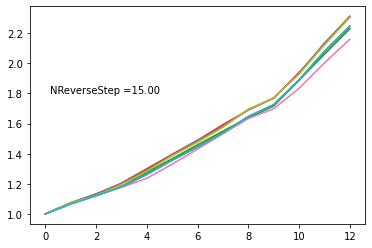

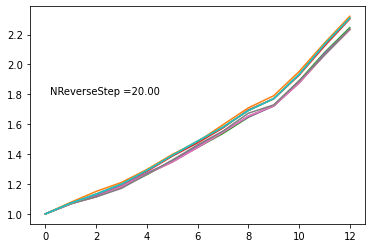

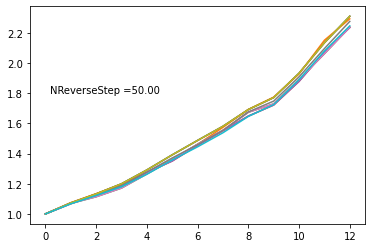

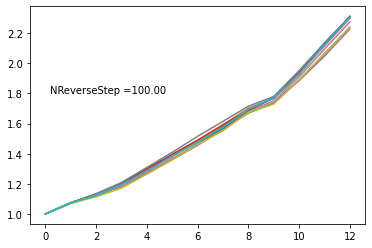

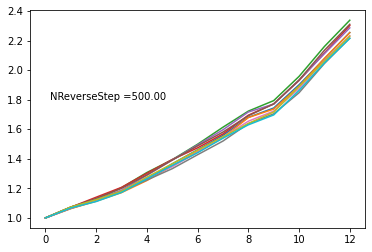

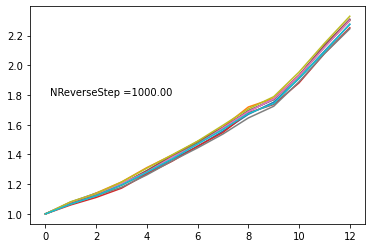

In [20]:
for NReverseStep in [1,2,5,10,15,20,50,100,500,1000]:
    #Create RQA schedule
    RQAschedule = []
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.text(0.2,1.8, "NReverseStep ="+'{:.2f}'.format(NReverseStep))
    plt.show()

またMC stepsに関しては、分割数×MC stepsが極端に少ない場合でなければ、最終の結果にはほぼ影響がないことが分かった。`SQASampler()`がデフォルト設定の場合、目安として$1000$程度で問題なく動作するはずである。

#### Pause Phaseの場合
既に説明があったように、通常の場合Pause PhaseがReverse Phaseの最後のステップを延長させたものに違いないので、アニーリング全体の$s$と$\beta$を変化させたところで、Reverse Phaseと同じようなふるまいをする。また、ステップ数もどのぐらい最後のステップを伸ばすのかに等しい意味なので、変更してもほぼReverse Phaseの状態を保持したままだけで、影響が少ない。

ただし、Pause Phaseだけ$\beta$を変化させることは量子アニーリングが不完全な状態で古典的なアニーリングを行うの近い行動である。ここでは$\beta=5.0$から緩やかに目標とした$\beta$に向かって系の温度を変化させて、その影響を調べる。そして、Reverse Phaseで異なる$\beta$でアニーリングを行った場合の終状態に近い結果を得られた。

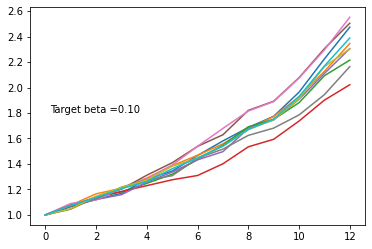

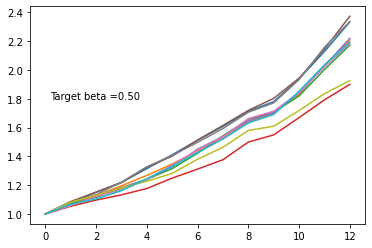

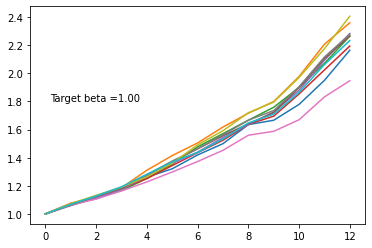

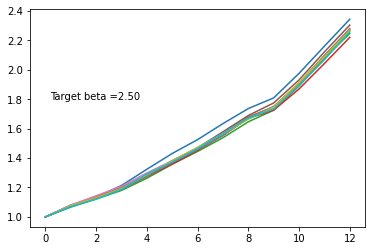

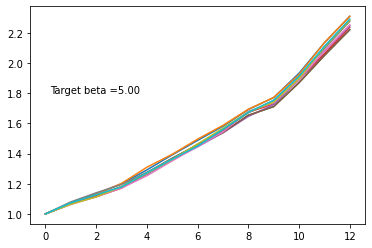

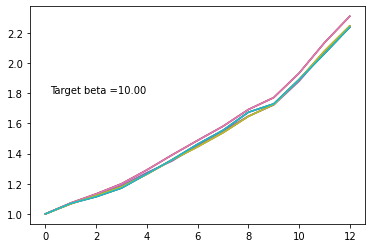

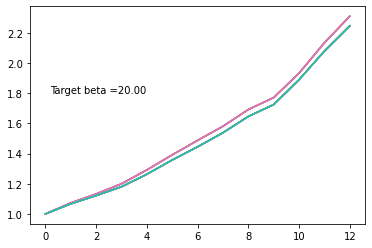

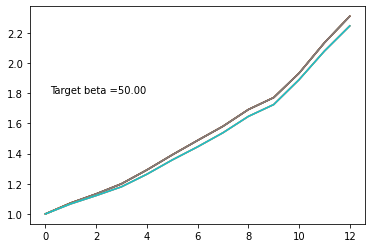

In [21]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
        RQAschedule.append(step_sche) 
    
    #Pause Phase
    NPauseStep = 50
    betaStep = (5.0-beta) / NPauseStep
    for i in range(NReverseStep):
        step_sche = [TargetS, 5.0-i*betaStep, MC_step]
        RQAschedule.append(step_sche) 

    init_state = QA_init_state 


    sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse_Pause.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.text(0.2,1.8, "Target beta ="+'{:.2f}'.format(beta))
    plt.show()

#### Forward Phaseの場合
Forwar PhaseはReverse PhaseとPause Phaseで得られた状態から普通の量子アニーリングを行う。このとき考えるぺきパラメータの条件は通常のアニーリングが正しく動作するために必要な条件と基本同じである。Reverse PhaseとPause Phaseと同じ方法で、$\beta$と分割したステップ数のスキャンを行った結果、比較的に小さい分割数と$\beta$でも結果がちゃんと最適解に収束することが分かった。

下のコードはその例である。Reverse PhaseとPause Phaseは上の調査で得られた設定で、Forward Phaseだけ粗い分解と小さい$\beta$でアニーリングを行っている。

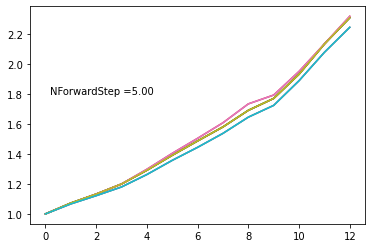

In [22]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.18
ReverseStep = (1.0 - TargetS) / NReverseStep
MC_step = 20
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
    RQAschedule.append(step_sche) 
    
#Pause Phase
NPauseStep = 50
step_sche = [TargetS, 5.0, MC_step*NPauseStep]
RQAschedule.append(step_sche) 

#Forward Phase
NForwardStep = 5
ForwardStep = (1.0 - TargetS) / NForwardStep
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, 2.5, MC_step]
    RQAschedule.append(step_sche)

init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
plt.text(0.2,1.8, "NForwardStep ="+'{:.2f}'.format(NForwardStep))
plt.show()

## 終わりに

以上のように、OpenJijを用いて、Reverse Quantum Annealingを実装してポートフォリオ最適化問題を解いた。このチュートリアルをは、RQAの問題定式化やスケジュール指定のやり方、そしてRQAを行う時考慮すべきパラメータなどの説明を行った。また結果として、RQAの手法を用いることで、正しく最適解となる答えを得られることを示した。

ほかの最適解付近にsub-optimalな解が多く存在する問題に関しても、同様な手法でより良い解を求められるので、通常の量子アニーリングでローカルミニマムにハマった時、このようにReverse Quantum Annealingを試して見ると解決できるかもしれない。

また、例えばスケジュールの変化が線形関数から非線形な形にした場合の影響など、RQAについてこのチュートリアルで議論しなかった部分もあるが、このチュートリアルにあるコードを変更することで簡単にできるので、興味がある方は是非試してみてください。


### 付録A シミュレーションの結果が上手くいかない場合
このチュートリアルで使用された銘柄セットの生成コードは必ずしても構成が「良い」銘柄を生成する保証がないので、場合によって偏った分布を持ったセットに対して実験する可能性もある。その時は、遺伝的アルゴリズムの計算が非常に長い時間を持つことや、チュートリアルがデフォルトで使用した$s$や$\beta$などのパラメータでRQAが収束しないこともある。そうした場合は銘柄セットを再生成するか、手動でRQAのパラメータ調整を行って最適解に収束するようにしてください。

### 付録B DwaveマシンでRQA実験をする場合のコード
Dwaveマシンにおいてもこのチュートリアルが実行した手法でRQAを実行できる。ここでは参考としてそのサンプルコードを載せる。実装及びシミュレーションと実機の違いで、スケジュールの設定方法や引数が異なるが、基本的には同じような過程になる。詳細を知りたい方はDwave公式サイトなどにあるドキュメントに参考してください。
また、実機では現実のノイズなどによる影響は見られやすいので通常のアニーリングとRQAによる結果の違いは見られやすい。

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite

token = '*** your user token ***'
endpoint = '*** your dwave endpoint***' #'https://cloud.dwavesys.com/sapi/' as defaults

dw_sampler = DWaveSampler(solver='Advantage_system4.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

Nassets = 48


# RQA schedule
timing = (0,1,2,3)#各フェーズの開始と終了時刻、フェーズの数を増やしても問題ない
Ratio = (1.0,0.38,0.38,1.0)#各フェーズが変わる時のs
schedule = list(zip(timing,Ratio))#スケジュールにまとめる
plt.plot(timing,Ratio)
plt.show()

#Create QUBO
QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

#FQA
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

min_forword = 0
for result in sampleset.record:
    if result[1] < min_forword:
        min_forword = result[1]
        best_forword = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_forword[i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA,color="r",label="Forward Annealing")

#RQA
sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10,  anneal_schedule=schedule, initial_state = QA_init_state)
print(sampleset_RQA.record)

min_RQA = 0
for result in sampleset_RQA.record:
    if result[1] < min_RQA:
        min_RQA = result[1]
        best_RQA = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_RQA[i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_RQA,color="b",label="Reverse Annealing")
plt.legend()
plt.show()


## 参考文献
1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)
3. Sharpe, William F., “Mutual fund performance”, The Journal of Business 39 (1), 119-138 (1966)
